In [1]:
dataset = 'kaggle.com/datasets/kumarajarshi/life-expectancy-who'

In [2]:
data_dir = './life-expectancy-who'

import os
os.listdir(data_dir)
!pip install skillsnetwork[regular]
from tqdm import tqdm
!pip install opendatasets --upgrade
import opendatasets as od
od.download(dataset)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('dark')
sns.set_style('ticks')

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, KFold, cross_val_predict

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

Skipping, found downloaded files in "./life-expectancy-who" (use force=True to force download)


In [3]:
data = pd.read_csv('Life Expectancy Data.csv')
data.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
128,Austria,2015,Developed,81.5,65.0,0,NaN,0.000000,93.0,309,...,93.0,NaN,93.0,0.1,43665.947000,8633169.0,1.9,2.1,0.892,15.9
1316,Japan,2013,Developed,83.5,56.0,2,7.55,94.434286,NaN,229,...,99.0,1.25,96.0,0.1,4454.447460,127445.0,2.0,1.7,0.894,15.3
16,Albania,2015,Developing,77.8,74.0,0,4.60,364.975229,99.0,0,...,99.0,6.00,99.0,0.1,3954.227830,28873.0,1.2,1.3,0.762,14.2
2265,Serbia,2015,Developing,75.6,121.0,1,NaN,0.000000,94.0,383,...,95.0,NaN,95.0,0.1,5237.255334,795383.0,2.0,2.0,0.775,14.4
2475,Suriname,2013,Developing,71.2,179.0,0,6.02,1122.972967,86.0,0,...,86.0,5.96,86.0,0.4,9484.568980,54254.0,3.5,3.5,0.719,12.7


In [4]:
data.rename(columns={data.columns[3]:'Life expectancy',
                     data.columns[4]:'Adult mortality',
                     data.columns[5]:'Infant deaths',
                     data.columns[7]:'Health expenditure',
                     data.columns[9]:'Measles',
                     data.columns[10]:'BMI',
                     data.columns[11]:'Under-5 deaths',
                     data.columns[14]:'Diphtheria',
                     data.columns[15]:'HIV/AIDS',
                     data.columns[18]:'Thinness (1-19 years)',
                     data.columns[19]:'Thinness (5-9 years)'},
                    inplace=True)

data = data.drop('Country',axis=1)

null_count = data.isnull().sum()
print(null_count[null_count>0].sort_values(ascending=False),
      'Number of null entries:',null_count.sum())

for column in data:
    if data[column].isnull().sum() > 0:
        median = data[column].median()
        data[column].fillna(median,inplace=True)
null_count = data.isnull().sum()

print('Number of duplicated rows:',data.duplicated().sum())

print('Number of 0 entries in \'Health expenditure\' column:',pd.DataFrame(data['Health expenditure']).value_counts()[0])
data = data.loc[data['Health expenditure']>0]

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
BMI                                 34
Thinness (1-19 years)               34
Thinness (5-9 years)                34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult mortality                     10
dtype: int64 Number of null entries: 2563
Number of duplicated rows: 0
Number of 0 entries in 'Health expenditure' column: 611


In [5]:
data = pd.get_dummies(data, columns=['Status'],drop_first=True)
data.rename(columns={'Status_Developing':'Developing status'},inplace=True)

y_col = 'Life expectancy'
x_cols = [x for x in data.columns if x!=y_col]
x_data = data[x_cols]
y_data = data[y_col]

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.25,random_state=42)

print(x_train.shape[0],'train samples')
print(x_test.shape[0],'test samples')

poly = PolynomialFeatures(degree=2,include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_poly = poly.transform(x_data)

print(x_train_poly.shape[1],'features')

1745 train samples
582 test samples
230 features


In [6]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

pd.Series({'Test set MSE':mean_squared_error(y_test,y_pred),
           'Test set R^2':r2_score(y_test,y_pred)})

Test set MSE    16.960130
Test set R^2     0.834491
dtype: float64

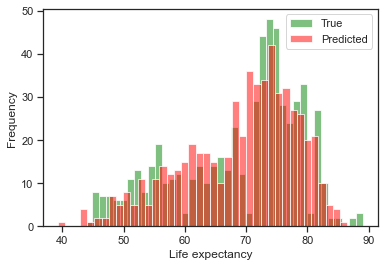

In [7]:
plt.figure()
ax = plt.axes()
ax.set(ylabel='Frequency')
sns.histplot(y_test,bins=40,alpha=.5,label='True',color='green',ax=ax)
sns.histplot(y_pred,bins=40,alpha=.5,label='Predicted',color='red')
plt.legend(loc='upper right')

[Text(0.5, 0, 'True'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Linear Regression on Life Expectancy (w/out Polynomial Features)')]

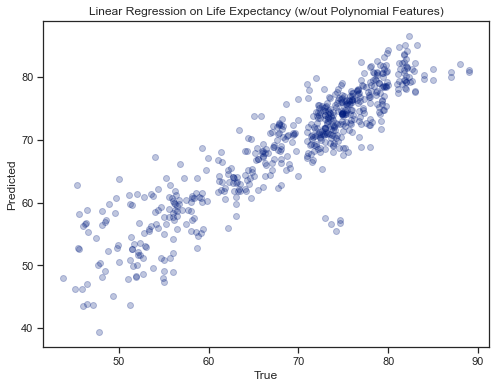

In [8]:
plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(y_test,y_pred,alpha=.25)
ax.set(xlabel='True',ylabel='Predicted',title='Linear Regression on Life Expectancy (w/out Polynomial Features)')

In [9]:
lr = LinearRegression()
lr.fit(x_train_poly,y_train)
y_pred = lr.predict(x_test_poly)

pd.Series({'Test set (+PF) MSE':mean_squared_error(y_test,y_pred),
           'Test set (+PF) R^2':r2_score(y_test,y_pred)})

Test set (+PF) MSE    11.666972
Test set (+PF) R^2     0.886146
dtype: float64

[Text(0.5, 0, 'True'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Linear Regression on Life Expectancy')]

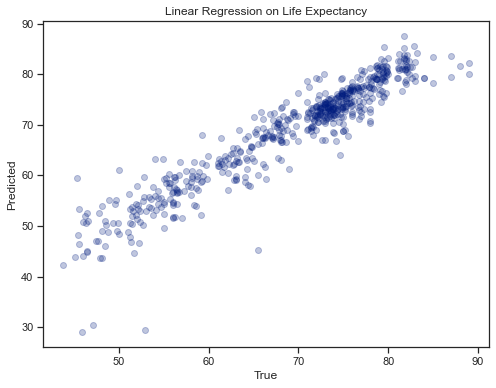

In [10]:
plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(y_test,y_pred,alpha=.25)
ax.set(xlabel='True',ylabel='Predicted',title='Linear Regression on Life Expectancy')

In [11]:
kf = KFold(n_splits=4,random_state=4444,shuffle=True)
alphas = np.geomspace(1e-9,1e0,num=10)

s = StandardScaler()
las = Lasso()
las.fit(x_train_poly,y_train)
las_scores = []

for alpha in alphas:
    las = Lasso(alpha=alpha,max_iter=10000)
    estimator = Pipeline([('scaler',s),('lasso',las)])
    y_pred_las = cross_val_predict(estimator,x_test_poly,y_test,cv=kf)
    score = r2_score(y_test,y_pred_las)
    las_scores.append(score)
    
las_scores

[-0.4528964619673852,
 -0.45285556149124107,
 -0.4524465921506582,
 -0.4483607860911394,
 -0.40866887870076707,
 -0.09671242382332101,
 0.7042338960996948,
 0.8634714826020344,
 0.8747031304987349,
 0.8238309611529988]

[Text(0.5, 0, 'True'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'LASSO Regression on Life Expectancy')]

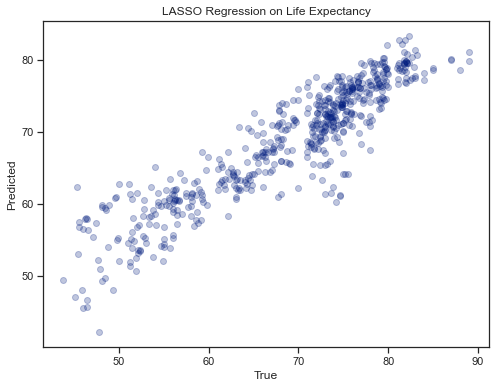

In [12]:
plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(y_test,y_pred_las,alpha=.25)
ax.set(xlabel='True',ylabel='Predicted',title='LASSO Regression on Life Expectancy')

In [13]:
rid = Ridge()
rid.fit(x_train_poly,y_train)
rid_scores = []

for alpha in alphas:
    rid = Ridge(alpha=alpha,max_iter=100000)
    estimator = Pipeline([('scaler',s),('ridge',rid)])
    y_pred_rid = cross_val_predict(estimator,x_test_poly,y_test,cv=kf)
    score = r2_score(y_test,y_pred_rid)
    rid_scores.append(score)
    
rid_scores

[-6.293502748680986,
 -6.46463027369854,
 -7.150606351527879,
 -5.341507361296267,
 -2.676268093723712,
 -0.844148433319563,
 0.14946805622286297,
 0.3342788622449343,
 0.6728694879044297,
 0.8308620758170056]

[Text(0.5, 0, 'True'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Ridge Regression on Life Expectancy')]

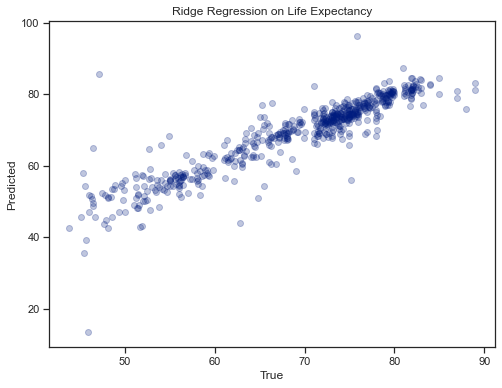

In [14]:
plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(y_test,y_pred_rid,alpha=.25)
ax.set(xlabel='True',ylabel='Predicted',title='Ridge Regression on Life Expectancy')

In [15]:
net = ElasticNet()
net.fit(x_train_poly,y_train)
net_scores = []

for alpha in alphas:
    net = ElasticNet(alpha=alpha,max_iter=100000)
    estimator = Pipeline([('scaler',s),('elastic_net',net)])
    y_pred_net = cross_val_predict(estimator,x_test_poly,y_test,cv=kf)
    score = r2_score(y_test,y_pred_net)
    net_scores.append(score)
    
net_scores

[-0.051639786627395656,
 -0.05124562511102715,
 -0.04733076999604546,
 -0.010696907391930077,
 0.19799763625477507,
 0.3946588899990101,
 0.786105238295189,
 0.8779803109011676,
 0.878521964218298,
 0.8274906604464803]

[Text(0.5, 0, 'True'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Elastic Net Regression on Life Expectancy')]

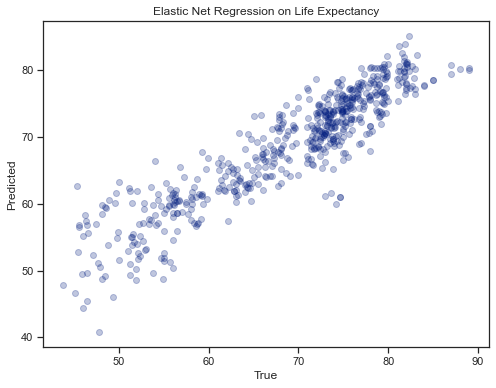

In [16]:
plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(y_test,y_pred_net,alpha=.25)
ax.set(xlabel='True',ylabel='Predicted',title='Elastic Net Regression on Life Expectancy')